# This notebook is a used for preliminary data exploration 

Data preprocessing:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Cleaning weather data, Cleaning microtensiometer data & down sampling 

In [2]:
from data_preprocessing import clean_weather_data, clean_mt_data, down_sample_df

Exploratory data analysis

In [3]:
# path to read the weather data:
weather_path = r'C:\Users\hl943\Documents\personal documents\data science\Insight DS\project directory\Napa_weather_data_test.csv'
# path to read the microtensiometer data:
mT_path_1 =  r'C:\Users\hl943\Documents\personal documents\data science\Insight DS\project directory\M36_grape.csv'
mT_path_2 =  r'C:\Users\hl943\Documents\personal documents\data science\Insight DS\project directory\M37_grape.csv'

# Get weather dataframe
df_weather = down_sample_df(clean_weather_data(weather_path))

#some more feature cleaning
df_weather['incident energy'] = df_weather['Sol Rad (W/sq.m)']*df_weather['sunshine duration']/60/1000
df_weather.drop('Sol Rad (W/sq.m)', axis=1, inplace=True)
df_weather.drop('sunshine duration', axis=1, inplace=True)
# df_weather.drop('ETo (mm)', axis=1, inplace=True)
df_weather.drop('Eto simulated', axis=1, inplace=True)


df_mt1 = down_sample_df(clean_mt_data(mT_path_1))
df_mt2 = down_sample_df(clean_mt_data(mT_path_2))
df_data = df_weather.join(df_mt1)
#df_data = df_data.join(df_mt2)
df_data = df_data.dropna()


In [4]:
df_data.head()

,Hour (PST),Day of the Year,ETo (mm),Precip (mm),Vap Pres (kPa),Air Temp (C),Rel Hum (%),Dew Point (C),Wind Speed (m/s),Soil Temp (C),Soil moisture content,VPD,incident energy,Averaged reading M36_grape.csv
Datetime,,,,,,,,,,,,,,
2019-06-03 16:00:00,1600.0,0.421918,0.59,0.0,2.1,29.013168,0.55,18.4,4.3,21.9,0.220,17.206190,0.683000,0.00
2019-06-05 17:00:00,1700.0,0.427397,0.44,0.0,2.1,31.493168,0.46,18.4,3.6,23.9,0.211,23.820477,0.427505,-0.03
2019-06-05 18:00:00,1800.0,0.427397,0.28,0.0,2.1,30.153168,0.50,18.3,3.7,23.9,0.210,20.423243,0.000000,-0.03
2019-06-05 19:00:00,1900.0,0.427397,0.17,0.0,1.9,28.243168,0.57,16.7,4.2,23.8,0.210,15.719130,0.000000,-0.03
2019-06-05 20:00:00,2000.0,0.427397,0.07,0.0,1.7,25.533167,0.67,15.0,4.0,23.6,0.209,10.277420,0.000000,-0.04


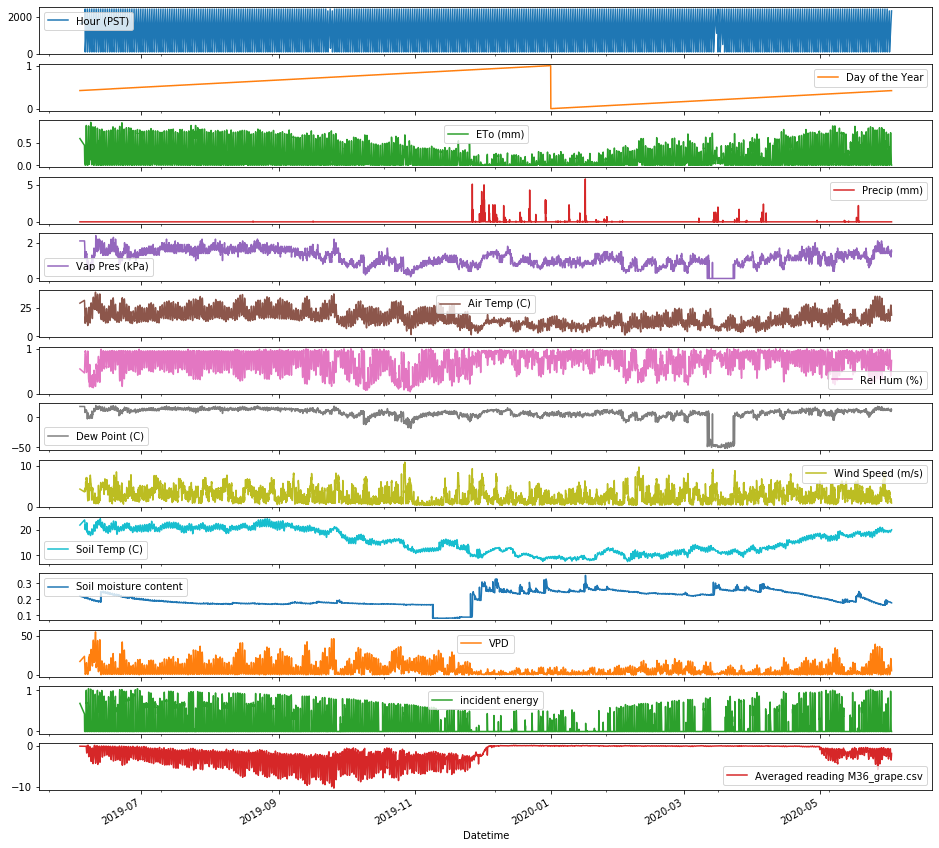

In [5]:
# some more feature engineering
df_data.plot(subplots=True, layout=(len(df_data.columns), 1), figsize=(16, 16), sharex=True);

## some observations from plots ##

1. The bulk of precipitation take place outside of growing seasons, thus it seemed that the natural precipitation does not play an important role in informing irrigation.

2. The off season with no growth, may exclude it. 

3. ET and solar radiation look similar, maybe only one feature is needed

4. The two mT readings has some variations not sure what to look at first

5. Think about making prediction with daily Max. vs hourly data.

6. There are long term trend of the season annually

7. One entire growing season should be a good time period to build a predictive model


# More data cleaning and feature engineering

In [ ]:
# defining the features and labels

#drop some features:
df_data.drop(columns = 'Vap Pres (kPa)',inplace=True)
df_data.drop(columns = 'Dew Point (C)',inplace=True)


start = '2019-06-05 00:00:00'
end = '2019-12-05 00:00:00'
df_data_2019 = df_data[start:end]
df_data_2019.plot(subplots=True, layout=(len(df_data.columns), 1), figsize=(16, 16), sharex=True);

In [ ]:
# defining the features and labels
start = '2020-05-01 00:00:00'
end = '2020-06-01 00:00:00'
df_data_2020 = df_data[start:end]
df_data_2020.plot(subplots=True, layout=(len(df_data.columns), 1), figsize=(16, 16), sharex=True);

# Mutli-variate LSTM

In [ ]:
# multivariate lstm example
import numpy as np
from numpy import array
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tools.eval_measures import rmse
from tensorflow.keras.preprocessing import sequence


def train_test_split(X,Y, split_size):
    assert(X.shape[0]==Y.shape[0])
    n = X.shape[0]
    n_tr = int((n*split_size))
    Xtr = X[:n_tr,:]
    Xte = X[n_tr+1:,:]
    Ytr = Y[:n_tr,:]
    Yte = Y[n_tr+1:,:]
    return Xtr, Xte, Ytr, Yte

def scale(train, test):
    scaler = StandardScaler()
    scaler = scaler.fit(train)
    
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)   

    return scaler, train_scaled, test_scaled


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Try using keras's built in function for time-series generator
def sequence_generator(sequences, strides, length, batch_size, sampling_rate=1):
    targets = sequences[:,-1]
    sequences = sequences[:,:-1]
    data_gen = sequence.TimeseriesGenerator(sequences, targets, length, sampling_rate, batch_size)
    return data_gen

def build_model(Xtr, Ytr, n_steps):
    #reframe to sequences
    Xtr_seq, Ytr_seq = split_sequences(np.hstack((Xtr,Ytr)), n_steps)
    Ytr_seq=Ytr_seq.reshape(-1,1)
    Xtr_seq, Xte_seq, Ytr_seq, Yte_seq = train_test_split(Xtr_seq,Ytr_seq, 0.8)

    # Train and validation 
    n_features = Xtr_seq.shape[2]
    
    #LSTM model
    model = Sequential()
    #add convolution and max pooling layer
#     model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
#     model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
    model.add(Bidirectional(LSTM(128, return_sequences=False), merge_mode='concat'))
#     model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001), loss='mse')
    history = model.fit(Xtr_seq, Ytr_seq, batch_size=16, epochs=100, verbose=2,validation_data=(Xte_seq, Yte_seq))    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model

# make a forecast
def forecast(model, Xte, n_steps):
    dummy_y = np.zeros((Xte.shape[0],1))
    Xte_seq, _= split_sequences(np.hstack((Xte,dummy_y)), n_steps)
    yhat = model.predict(Xte_seq, verbose=0)
    # we only want the vector forecast
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores



In [ ]:
# define dataset
def df_to_train_test(df, split_size):
    df=df.values
    X=df[:, :-1]
    Y=df[:,-1].reshape((-1,1))
    Xtr, Xte, Ytr, Yte = train_test_split(X, Y, split_size)
    scaler, Xtr_scaled, Xte_scaled = scale(Xtr, Xte)
    return scaler, Xtr_scaled, Xte_scaled, Ytr, Yte
# Train on 2019 data
split_size = 0.8
scaler, Xtr_scaled, Xte_scaled, Ytr, Yte = df_to_train_test(df_data_2019, split_size)

In [ ]:
# Define and train model
n_steps=6
model = build_model(Xtr_scaled, Ytr, n_steps)


In [ ]:
# training data vs. model
Y_pred = forecast(model, Xtr_scaled, n_steps)
Y_pred = np.array(Y_pred).flatten()
fig1=plt.figure(1)
plt.plot(Y_pred[:1000],color='blue', label='Original')
plt.plot(Ytr[:1000],color='red',label='Model')
plt.legend()

# test data vs. model
Xte_scaled_2019 = scaler.transform(Xte)
Y_pred_2019 = forecast(model, Xte_scaled_2019, n_steps)
Y_pred_2019 = np.array(Y_pred_2019).flatten()
Yte_2019=Yte
fig2 = plt.figure(2)
plt.plot(Yte_2019,color='blue', label='Original')
plt.plot(Y_pred_2019,color='red',label='Model')
plt.legend()

# LR_data_2020 = df_data['2020-05-01 00:00:00':'2020-06-01 00:00:00']
LSTM_data_2020 = df_data_2020.values
Xte_2020 = LSTM_data_2020[:, :-1]
Xte_2020_scaled = scaler.transform(Xte_2020)
Yte_2020 = LSTM_data_2020[:,-1:]
Y_pred_2020 = forecast(model, Xte_2020_scaled, n_steps)
Y_pred_2020 = np.array(Y_pred_2020).flatten()
fig3 = plt.figure(3)
plt.plot(Yte_2020,color='blue', label='Original')
plt.plot(Y_pred_2020-1,color='red',label='Model')
plt.legend()

# Now figure how how to pickle a model


In [ ]:
# 
df_mt2 = down_sample_df(clean_mt_data(mT_path_2))
df_data_test = df_data_2019.copy()
df_data_test.drop(columns='Averaged reading M36_grape.csv', inplace =True)
df_data_test =df_data_test.join(df_mt2)

# 2019 data
start = '2019-06-01 00:00:00'
end = '2019-12-05 00:00:00'
df_data_test_2019 = df_data_test[start:end]

split_size = 0.95
scaler, Xtr_scaled, Xte_scaled, Ytr, Yte = df_to_train_test(df_data_test_2019, split_size)

Y_pred = forecast(model, Xtr_scaled, n_steps)
Y_pred = np.array(Y_pred).flatten()
fig1=plt.figure(1)
plt.plot(Y_pred,color='blue', label='Original')
plt.plot(Ytr,color='red',label='Model')
plt.legend()


# VAR

In [ ]:
# Preprocess data for VAR
df_diff = df_data_2019.diff(periods=24)
# df_diff.plot(subplots=True, layout=(len(df_data.columns), 1), figsize=(16, 16), sharex=True)
# plt.show()

In [ ]:
# df_diff.drop(columns='Hour (PST)', inplace = True)
# df_diff.drop(columns='Day of the Year', inplace =True)
df_diff.dropna(inplace=True)

In [ ]:
# define and fit model 
### FIND BEST VAR ORDER ###
from statsmodels.tsa.vector_ar.var_model import VAR

def tune_VAR(train, max_lags):
    BIC = {}
    best_bic, best_order = np.inf, 0

    for i in range(1,max_lags):
        model = VAR(endog=train)
        model_result = model.fit(maxlags=i)
        BIC[i] = model_result.bic

        if BIC[i] < best_bic:
            best_aic = BIC[i]
            best_order = i

    print('BEST ORDER', best_order, 'BEST bic:', best_bic)
    best_model = model.fit(best_order)
    return best_model, best_order, BIC

In [ ]:
date = '2019-10-01 14:00'
train_diff = df_diff.loc[:date]
var = VAR(endog=df_diff.values)
best_model, best_order, best_aic = tune_VAR(df_diff.values, 180)
var_result = var.fit(maxlags=best_order)


In [ ]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
# plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,10))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [ ]:
def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

In [ ]:
date = '2019-09-01 14:00'
forward = 480
date_range = pd.date_range(date, periods=forward+1, freq='H', closed='right')

final_pred = retrive_prediction(df_diff.loc[:date], df_data_2019.loc[:date], steps = forward)
final_true = df.loc[date_range]